In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from cmath import exp,pi
def turtlePath2Points(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,loops=1,return_heading=False,return_start_point=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0/abs(a0)
  p=p0
  p-=1j*a*offs
  if return_start_point:
      yield p
  for _ in range(loops):
      for l,da in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda


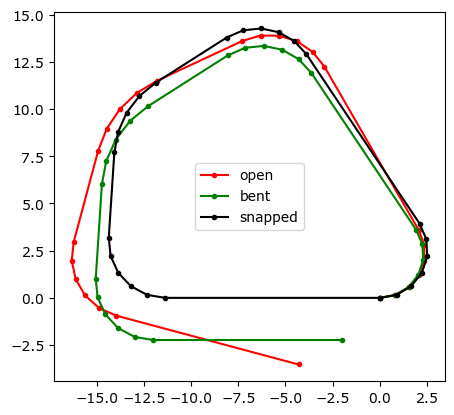

In [3]:
#making ends meet, step-by-step 
from math import pi
deg=pi/180
#example path
turtlePath=[(5,120*deg),(10,0),(5,85*deg),(5,0),(5,50*deg),(5,0),(5,90*deg),(10,0)]
#plot the example path
turtlePath=np.array(turtlePath)
unsnappedPoints=np.array(list(turtlePath2Points(turtlePath,p0=0,a0=1,return_start_point=True)))
plt.plot(unsnappedPoints.real,unsnappedPoints.imag,'r.-',zorder=5,label='open')

#now adjust all angles so that the heading at the end of the path matches the heading at the start
bentPath=turtlePath.copy()
bendable= bentPath.T[1].nonzero()[0] #do not bend straight line segments
#distribute the heading mismatch evenly over all bendable segmentsm
bentPath[bendable,1]-=((sum(bentPath[bendable][:,1])+pi)%(2*pi)-pi)/len(bendable)
#plot the "bent" turtle path
bentPoints=np.array(list(turtlePath2Points(bentPath,p0=0,a0=1,return_start_point=True)))
plt.plot(bentPoints.real,bentPoints.imag,'g.-',zorder=5,label='bent')

#now make end=start by adjusting all "stretchable" segments
snappedPath=bentPath.copy()
stretchable= snappedPath.T[0].nonzero()[0]#do not try to stretch sharp corners
Segs=snappedPath
nSegs=len(Segs)
dl,dang=Segs.T
l=sum(dl)
ang=np.cumsum(dang)
ang=np.exp(1j*np.insert( ang,0,0))
dang_2=np.exp(1j*dang/2)
viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
psec=np.insert(np.cumsum(viSeg),0,0)
#plt.plot(psec.real,psec.imag,'g.:',zorder=5,label='secants, bent')

pend=np.sum(viSeg)
def solve_ill(A, b, lam=0):
    #solve ill conditioned system of linear equations using the Tichonov regularization method
    return np.linalg.solve(A.T.dot(A) + lam * np.identity(A.shape[1]), A.T.dot(b))
b=np.array([pend.real,pend.imag])
A=np.vstack((viSeg[stretchable].real,viSeg[stretchable].imag))
a=solve_ill(A,b,1e-6) 
stretchfactor=1-a/np.abs(viSeg[stretchable])*np.abs(viSeg[stretchable])
viSeg1=viSeg.copy()
viSeg1*=stretchfactor
psec=np.insert(np.cumsum(viSeg1),0,0)
#plt.plot(psec.real,psec.imag,'k.:',zorder=4,label='secants, snapped')
snappedPath[stretchable,0]*=stretchfactor
#plot the result for the closet("snapped") turtle path:
snappedPoints=np.array(list(turtlePath2Points(snappedPath,p0=0,a0=1,return_start_point=True)))
plt.plot(snappedPoints.real,snappedPoints.imag,'k.-',zorder=5,label='snapped')
plt.legend()
plt.gca().set_aspect('equal') 


In [48]:
def snapTurtle(turtlePath,p_snap=0.0+0.0j,ang_snap=0.0,bendable_segments=None,stretchable_segments=None,unbendable_segments=None,unstretchable_segments=None):
    '''"snapTurtle" is a function that turns an open turtle path into a closed one. 
        This is accomplished adjusting the angles of each arc segment so that start and end heading match, 
        and by adjusting the length of each arc segment so that end and start point coordinates match. 
        At least one bendable, and two non-parallel stretchable segments are required for this to work.
        Optional parameters: 
                         p_snap: the point to which the end of the path should snap. Default is 0+0j
                       ang_snap: the angle to which the end of the path should snap. Default is 1+0j(or 0.0)
              bendable_segments: list of segments. The default is all segments except straight lines are bendable.
           stretchable_segments: list of segments. 
            unbendable_segments: list of segments. Can be used instead of "bendable_segments" if this is nore convenient.
         unstretchable_segments: list of segments. Can be used instead of "stretchable segments" if this is more convenient.
    '''
    bentPath=np.array(turtlePath)#make a copy
    if ang_snap!=None:
        #adjust all angles so that the heading at the end of the path matches the heading at the start
        if bendable_segments==None:
            if unbendable_segments!=None:
               bendable_segments= list(set(range(len(turtlePath)))-set(unbendable_segments))
            else:
               bendable_segments= bentPath.T[1].nonzero()[0] #do not bend straight line segments
             
        #distribute the heading mismatch evenly over all bendable segments
        

        if issubclass(type(ang_snap),complex):
            ang_snap=np.log(ang_snap).imag
        ang_sum=np.sum(bentPath[:,1])
        ang_mismatch=(ang_sum-ang_snap+pi)%(2*pi)-pi
        bentPath[bendable_segments,1]-=ang_mismatch/len(bendable_segments)
        ang_end=ang_sum-ang_mismatch #end angle after applying the correction
        
    #now adjust the length of each arc segment to make ends meet:
    snappedPath=bentPath.copy()
    if unstretchable_segments!=None:
        stretchable_segments= list(set(range(len(turtlePath)))-set(unstretchable_segments))
    else:    
        stretchable_segments= snappedPath.T[0].nonzero()[0]#do not try to stretch sharp corners
    dl,dang=snappedPath.T
    original_length=sum(dl)
    ang=np.insert(np.cumsum(dang),0,0)
    heading=np.exp(1j*ang)#unit vector for heading at start of each segment
    dang_2=np.exp(1j*dang/2)#rotation vector for half of the heading change: the direction of the secant
    viSeg=np.sinc(dang/(2*pi))*dl*dang_2*heading[:-1] #secant vectors

    p_end=np.sum(viSeg)#add it all up to get the end point
    if p_snap==None:
        p_snap=0+0j
        if (ang_end)<pi: #assume linear turtle path if less than 1/2 turn. Do not try to connect the start and end point.
#            p_end-=p_end.real #this sets the delta-x to zero
          return snappedPath
    p_mismatch=p_end-p_snap
    #set up and solve the system of linear equations 
    def solve_ill(A, b, lam=0):
        #solve ill conditioned system of linear equations using the Tichonov regularization method
        return np.linalg.solve(A.T.dot(A) + lam * np.identity(A.shape[1]), A.T.dot(b))
    b=np.array([p_mismatch.real,p_mismatch.imag])
    A=np.vstack((viSeg[stretchable_segments].real,viSeg[stretchable_segments].imag))
    a=solve_ill(A,b,1e-6) 
    stretchfactor=1-a
    snappedPath[stretchable_segments,0]*=stretchfactor
    return snappedPath

In [49]:
def twistTurtle(turtlePath,segment_index,rel_ang=0.0,ref_segment=None,abs_ang=None,**kwargs): 
    '''"twistTurtle" changes the orientation of a single segment.
       The new orientation can be specified relative to another segment, or absolute by
       passing the appropriate optional argument(s) to the function.'''
    if issubclass(type(rel_ang),complex): rel_ang=np.log(rel_ang).imag
    if ref_segment!=None: abs_ang=np.sum(turtlePath[:ref_segment,1])+turtlePath[ref_segment,1]/2
    if abs_ang!=None:
        if issubclass(type(abs_ang),complex):abs_ang=np.log(abs_ang).imag
        rel_ang+=abs_ang-np.sum(turtlePath[:segment_index,1])-turtlePath[segment_index,1]/2
    turtlePath=np.array(turtlePath)#make a copy
    rel_ang=(rel_ang+pi/2)%pi-pi/2#limit twist to +- pi/2
    turtlePath[segment_index-1,1]+=rel_ang
    turtlePath[segment_index+1,1]-=rel_ang
    return snapTurtle(turtlePath,**kwargs)

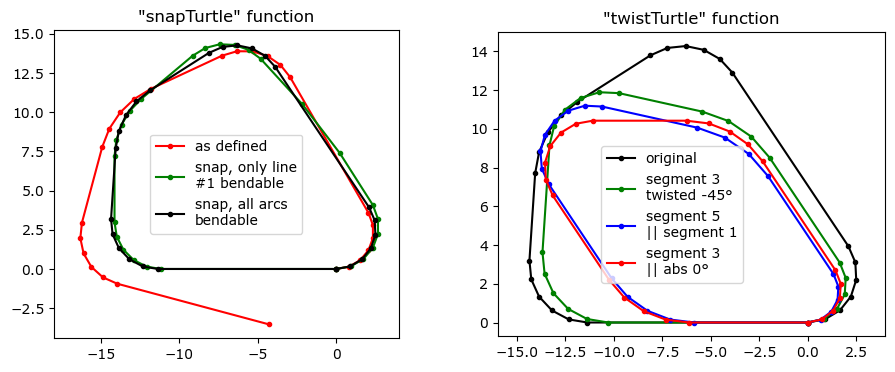

In [50]:
from math import pi
fig,ax=plt.subplots(1,2,figsize=(11, 4))
deg=pi/180

#example path
turtlePath=[(5,120*deg),(10,0),(5,85*deg),(5,0),(5,50*deg),(5,0),(5,90*deg),(10,0)]

unsnappedPoints=np.array(list(turtlePath2Points(turtlePath,p0=0,a0=1,return_start_point=True)))
ax[0].plot(unsnappedPoints.real,unsnappedPoints.imag,'r.-',zorder=5,label='as defined')

snappedPath=snapTurtle(turtlePath,bendable_segments=[1])

snappedPoints=np.array(list(turtlePath2Points(snappedPath,p0=0,a0=1,return_start_point=True)))
ax[0].plot(snappedPoints.real,snappedPoints.imag,'g.-',zorder=5,label='snap, only line\n#1 bendable')

snappedPath=snapTurtle(turtlePath)

snappedPoints=np.array(list(turtlePath2Points(snappedPath,p0=0,a0=1,return_start_point=True)))
ax[0].plot(snappedPoints.real,snappedPoints.imag,'k.-',zorder=5,label='snap, all arcs\nbendable')
ax[0].set_xlim(-18,4)
ax[0].legend(loc='center')
ax[0].set_title('"snapTurtle" function')
ax[0].set_aspect('equal') 

snappedPoints=np.array(list(turtlePath2Points(snappedPath,p0=0,a0=1,return_start_point=True)))
ax[1].plot(snappedPoints.real,snappedPoints.imag,'k.-',zorder=5,label='original')

twistedPath=twistTurtle(snappedPath,3,-45*deg)

twistedPoints=np.array(list(turtlePath2Points(twistedPath,p0=0,a0=1,return_start_point=True)))
ax[1].plot(twistedPoints.real,twistedPoints.imag,'g.-',zorder=5,label='segment 3 \ntwisted -45°')

twistedPath=twistTurtle(twistedPath,5,ref_segment=1)

twistedPoints=np.array(list(turtlePath2Points(twistedPath,p0=0,a0=1,return_start_point=True)))
ax[1].plot(twistedPoints.real,twistedPoints.imag,'b.-',zorder=5,label='segment 5\n|| segment 1')

twistedPath=twistTurtle(twistedPath,3,abs_ang=1+0j)

twistedPoints=np.array(list(turtlePath2Points(twistedPath,p0=0,a0=1,return_start_point=True)))
ax[1].plot(twistedPoints.real,twistedPoints.imag,'r.-',zorder=5,label='segment 3\n|| abs 0°')
ax[1].set_xlim(-16,4)
ax[1].legend(loc='center',bbox_to_anchor=(0.45,0.4))
ax[1].set_title('"twistTurtle" function') 
ax[1].set_aspect('equal') 

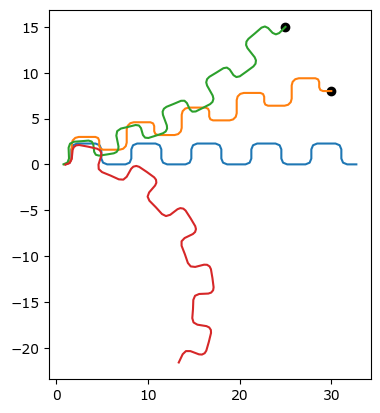

In [61]:
def mirror(segs):return segs+segs[-1::-1]
meanderPath=mirror([(1,0),(1,90*deg),(1,0),(1,-90*deg),(1,0)])*5
points=np.array(list( turtlePath2Points(meanderPath)))
plt.plot(points.real,points.imag)
plt.gca().set_aspect('equal')  
for pend,aend in [(30+8j,None),(25+15j,1+1j),( None,-0.5-1j)]:
    snappedPath=snapTurtle(meanderPath,p_snap=pend,ang_snap=aend,unbendable_segments=[])
    points=np.array(list( turtlePath2Points(snappedPath)))
    if pend!=None:
        plt.scatter(pend.real,pend.imag,c='k')
    plt.plot(points.real,points.imag)
#plt.legend()